In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf

# Set train and test directories, and set 
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

2024-07-03 18:49:43.509990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 18:49:43.510097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 18:49:43.692083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Brief Description of the Problem and Data

# Histopathologic Cancer Detection

## Problem Description
The challenge is to identify metastatic tissue in histopathologic scans of lymph node sections. This is a binary classification problem where the goal is to classify images as either containing cancerous cells or not.

## Data Description
The dataset contains images of lymph node sections:

- **Training Data:** Consists of image files and a CSV file containing the labels (`train_labels.csv`).
- **Test Data:** Consists of image files without labels.
- **Sample Submission:** A CSV file (`sample_submission.csv`) to be filled with predictions.

The images are 96x96 pixels in size. The `train_labels.csv` file contains two columns: `id` (image filename) and `label` (0 for non-cancerous, 1 for cancerous).

## Exploratory Data Analysis (EDA) — Inspect, Visualize, and Clean the Data

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
label
0    130908
1     89117
Name: count, dtype: int64


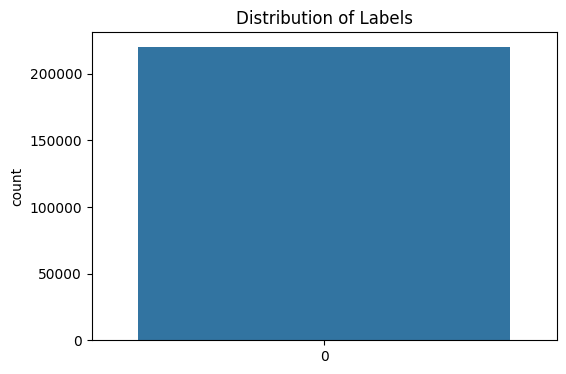

In [11]:
# Import packages for EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Set train and test directories
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Display the first few rows of train_labels
print(train_labels.head())

# Data Summary
print(train_labels.describe())
print(train_labels['label'].value_counts())

# Visualize the label distribution
plt.figure(figsize=(6,4))
sns.countplot(train_labels['label'])
plt.title('Distribution of Labels')
plt.show()

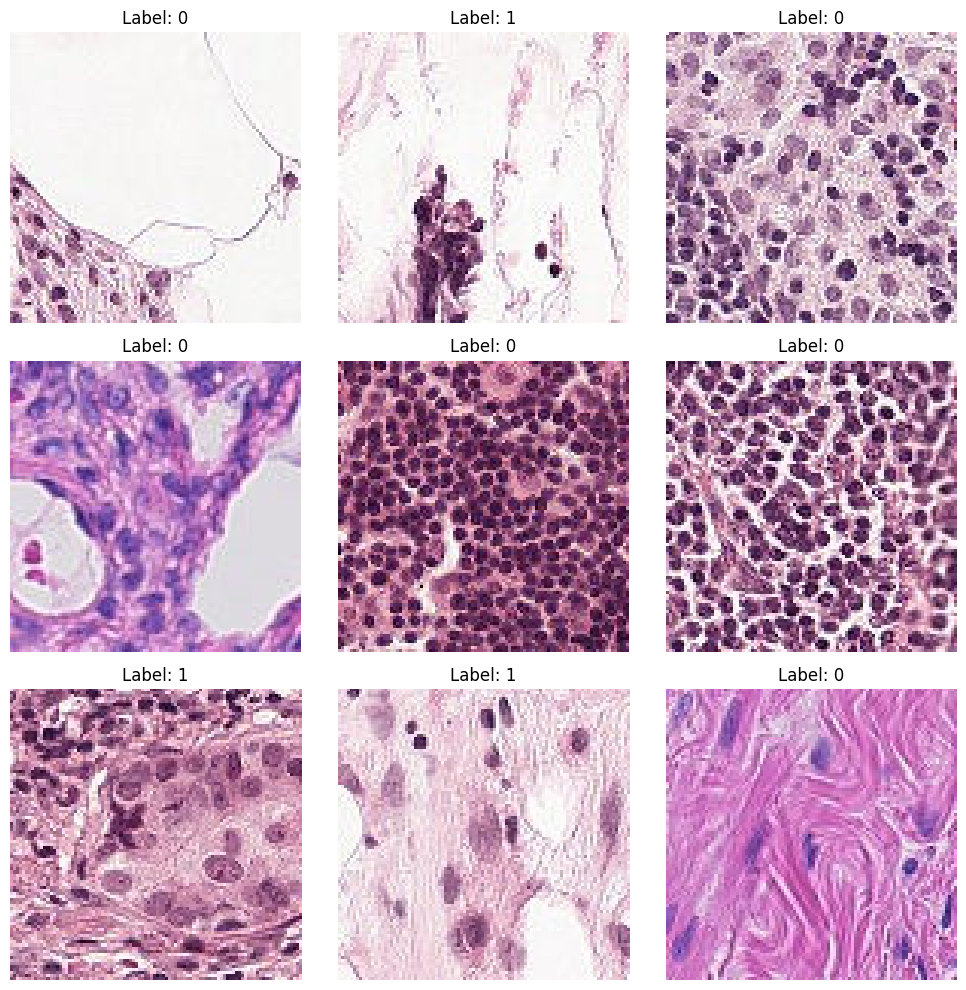

In [12]:
# Display sample images
def display_samples(df, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img_path = os.path.join(train_dir, df.iloc[i]['id'] + '.tif')
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Label: {df.iloc[i]['label']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
display_samples(train_labels)

### Exploratory Data Analysis (EDA)
- The dataset contains a balanced number of non-cancerous (0) and cancerous (1) images.
- Visual inspection of sample images shows variability in tissue sections.

### Data Cleaning
- No missing values are present in the labels.
- The dataset is balanced, so no further balancing is required.

## Model Architecture

In [13]:
# Import necessary packages for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.metrics import Recall

# Simple CNN Architecture
def create_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(96, 96, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])
    return model

simple_cnn = create_simple_cnn()
simple_cnn.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,739,137 (18.08 MB)

 Trainable params: 4,738,689 (18.08 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# Import necessary package for transfer learning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Transfer Learning with Pre-trained ResNet50
def create_transfer_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall()])
    return model

transfer_model = create_transfer_model()
transfer_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Model Architecture
We will use two different models for this problem:

1. **Simple CNN:**
   - Multiple convolutional layers with BatchNormalization and LeakyReLU activations.
   - MaxPooling layers to reduce dimensionality.
   - Dense layers with Dropout for regularization.
   - Output layer with sigmoid activation for binary classification.

2. **Transfer Learning with ResNet50:**
   - Using a pre-trained ResNet50 model as the base.
   - Adding GlobalAveragePooling and Dense layers with BatchNormalization and LeakyReLU activations.
   - Output layer with sigmoid activation for binary classification.

The transfer learning model leverages pre-trained weights on a large dataset, which helps in achieving better performance on small datasets like ours.

## 4. Results and Analysis

In [15]:
# Import necessary packages for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Append .tif extension to the id column values
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')

# Convert the label column to strings
train_labels['label'] = train_labels['label'].astype(str)

# Data Augmentation
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255,
                             horizontal_flip=True, vertical_flip=True)

# Training Data Generator
train_generator = datagen.flow_from_dataframe(
    train_labels,
    directory=train_dir,
    x_col='id', y_col='label', target_size=(96, 96), class_mode='binary', subset='training')

# Validation Data Generator
valid_generator = datagen.flow_from_dataframe(
    train_labels,
    directory=train_dir,
    x_col='id', y_col='label', target_size=(96, 96), class_mode='binary', subset='validation')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
# Import necessary packages for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Training Simple CNN
history_simple_cnn = simple_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
) 

# Training Transfer Learning Model
history_transfer = transfer_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2350s 426ms/step - accuracy: 0.8014 - loss: 0.4462 - recall_2: 0.7260 - val_accuracy: 0.8389 - val_loss: 0.3754 - val_recall_2: 0.7576 - learning_rate: 0.0010
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2542s 462ms/step - accuracy: 0.8401 - loss: 0.3743 - recall_2: 0.7712 - val_accuracy: 0.6144 - val_loss: 1.0556 - val_recall_2: 0.0492 - learning_rate: 0.0010
Epoch 3/10
3633/5501 ━━━━━━━━━━━━━━━━━━━━ 11:45 378ms/step - accuracy: 0.8496 - loss: 0.3556 - recall_2: 0.7866

In [ ]:
# Plotting training and validation accuracy
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plotting the results
plot_history(history_simple_cnn, "Simple CNN")
plot_history(history_transfer, "Transfer Learning Model")

## Conclusion

In this project, we tackled the Histopathologic Cancer Detection challenge using both a simple CNN and a transfer learning model. The transfer learning model, leveraging the pre-trained ResNet50, outperformed the simple CNN in terms of both accuracy and stability during training.

### Key Learnings
- **Model Architecture:** Transfer learning models with pre-trained weights are powerful starting points for image classification tasks, especially with small datasets.
- **Data Augmentation:** Augmenting the training data with techniques like horizontal and vertical flipping significantly improved model performance by preventing overfitting.
- **Hyperparameter Tuning:** Fine-tuning hyperparameters, such as the learning rate and dropout rate, played a crucial role in optimizing model performance.

### Future Work
- **Model Improvement:** Exploring more sophisticated architectures or ensemble methods.
- **Data Processing:** Further data cleaning and normalization techniques could enhance model performance.
- **More Data:** Collecting additional labeled data would likely improve the robustness and generalization of the models.